In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%config InlineBackend.figure_format = 'retina'
#az.style.use('arviz-darkgrid')
sns.set_style('darkgrid')

# PAR with synthetic data

In [3]:
N = 300 # number of datapoints

sigma_M = 1
sigma_R = 0.5
rho = 0.5

In [4]:
from statsmodels.tsa.arima_process import arma_generate_sample

np.random.seed(44)
ar_M = np.r_[1, -rho]
ar_R = np.r_[1, -1]
ma = np.r_[1]

M = arma_generate_sample(ar_M, ma, N, scale=sigma_M)
R = arma_generate_sample(ar_R, ma, N, scale=sigma_R)
X = M + R

Text(0.5, 1.0, 'Sum of both components')

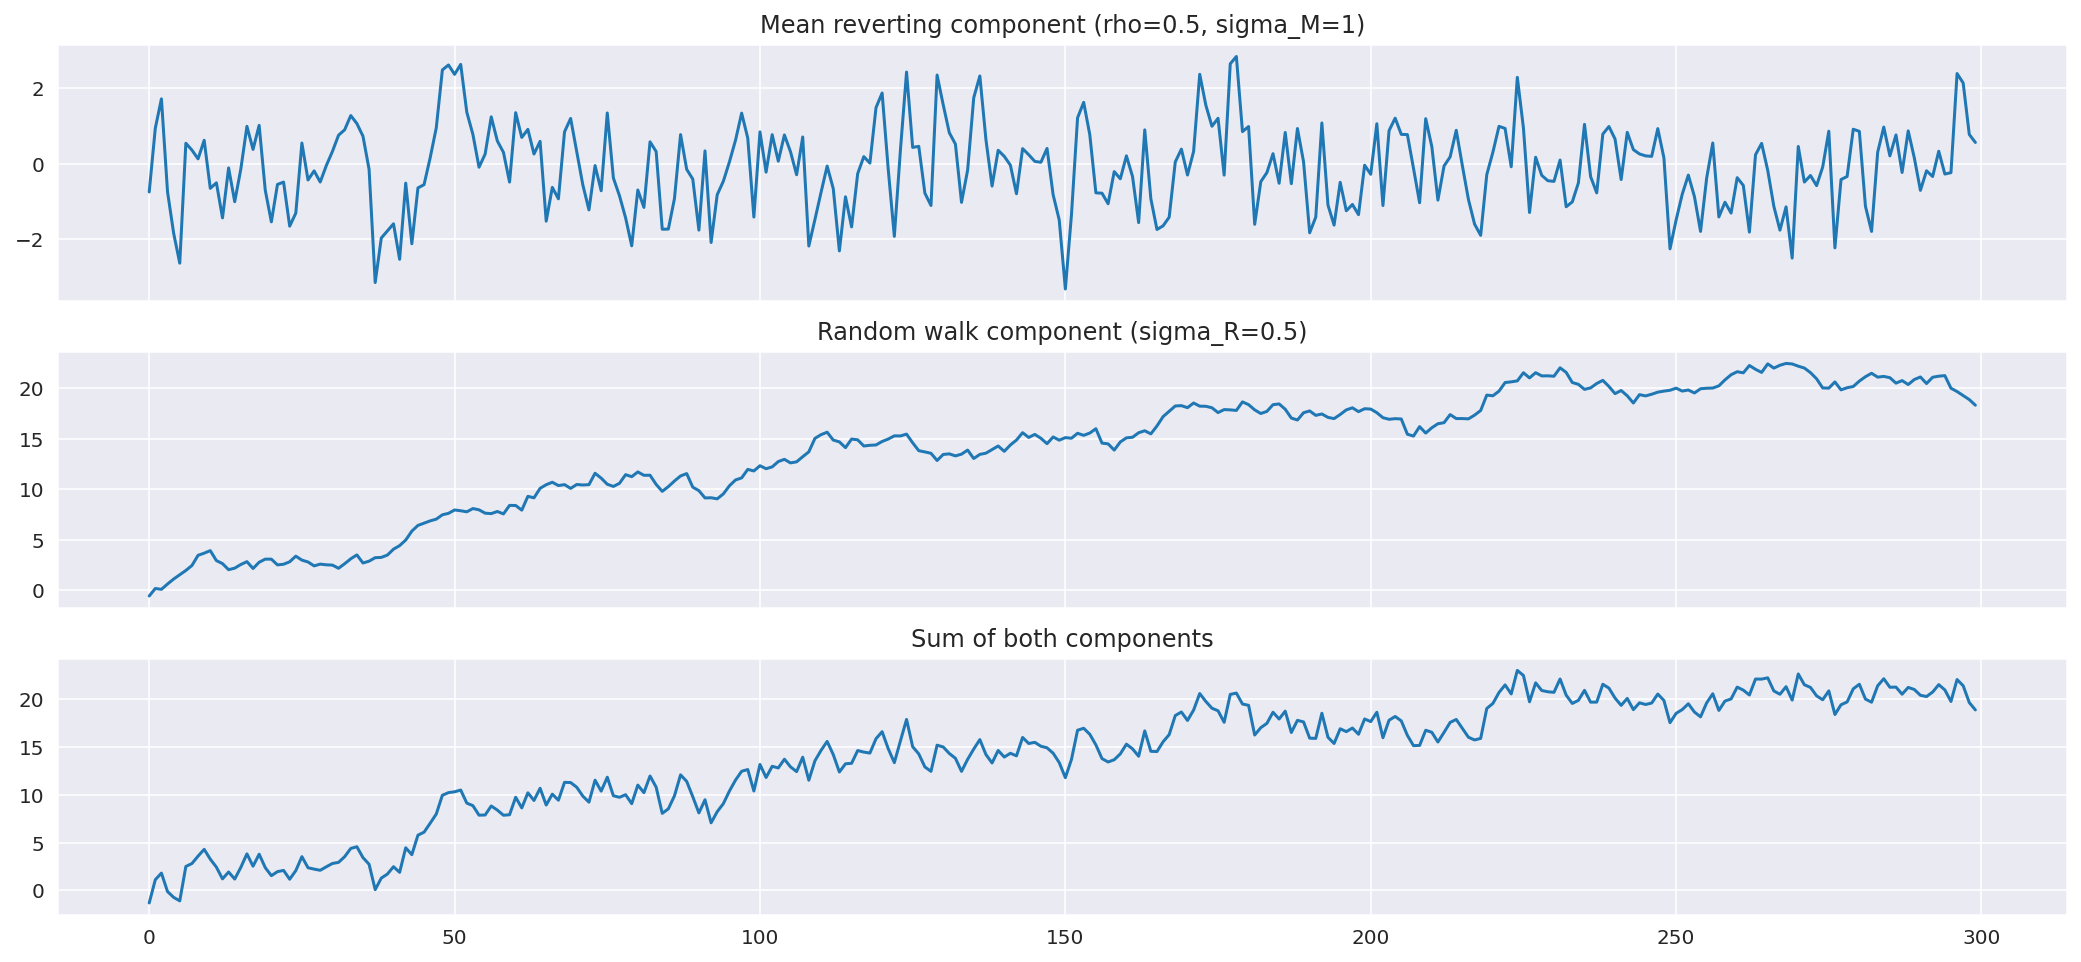

In [5]:
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(18,8), sharex=True)
ax1.plot(M)
ax1.set_title(f'Mean reverting component (rho={rho}, sigma_M={sigma_M})')
ax2.plot(R)
ax2.set_title(f'Random walk component (sigma_R={sigma_R})')
ax3.plot(X)
ax3.set_title('Sum of both components')

In [6]:
np.std(np.diff(R)) # sigma_R

0.4910008106257636

In [7]:
np.std(M[1:] - rho*M[:-1]) # sigma_M

1.0165856295123856

In [8]:
# proportion of variance attributable to mean reversion
(2*sigma_M**2) / (2*sigma_M**2 + (1+rho) * sigma_R**2)

0.8421052631578947

In [9]:
def generate_par(N, rho, sigma_M, sigma_R):
    '''
    Generate PAR sample of length N with parameters rho, sigma_M, sigma_R
    '''
    from statsmodels.tsa.arima_process import arma_generate_sample
    
    ar_M = np.r_[1, -rho]
    ar_R = np.r_[1, -1]
    ma = np.r_[1]

    M = arma_generate_sample(ar_M, ma, N, scale=sigma_M)
    R = arma_generate_sample(ar_R, ma, N, scale=sigma_R)
    
    return M+R

In [10]:
def calculate_Rsq(rho, sigma_M, sigma_R):
    '''
    Calculate R^2 - proportion of variance attributable to mean reversion
    '''    
    return (2*sigma_M**2) / (2*sigma_M**2 + (1+rho) * sigma_R**2)

# Estimate parameters using lagged variances

In [11]:
# generate a sample
N = 2500
sigma_M = 1
sigma_R = 0.5
rho = 0.5

np.random.seed(44)
X = generate_par(N, rho, sigma_M, sigma_R)

In [12]:
# calculate lagged variances
v1 = np.var(X[1:] - X[:-1])
v2 = np.var(X[2:] - X[:-2])
v3 = np.var(X[3:] - X[:-3])

In [13]:
# rho
rho_lv = -(v1 - 2*v2 + v3) / (2*v1 - v2)
rho_lv

0.5310977377515682

In [14]:
# sigma_M
sigma_M_lv = np.sqrt(1/2 * (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1))
sigma_M_lv

1.0296704460001678

In [16]:
# sigma_R
sigma_R_lv = np.sqrt(1/2 * (v2 - 2*sigma_M_lv**2))    
sigma_R_lv

0.4254865860508296

In [25]:
def lagvar_estimate_par(X):
    '''
    estimate parameters of partial AR model using lagged variances
    '''
    
    # calculate lagged variances
    v1 = np.var(X[1:] - X[:-1])
    v2 = np.var(X[2:] - X[:-2])
    v3 = np.var(X[3:] - X[:-3])
    
    # rho
    rho_lv = -(v1 - 2*v2 + v3) / (2*v1 - v2)
    
    # sigma_M
    if (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1) > 0:
        sigma_M = np.sqrt(1/2 * (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1))
    else:
        sigma_M = 0
        
    # sigma_R
    if v2 > 2*sigma_M_lv**2:
        sigma_R_lv = np.sqrt(1/2 * (v2 - 2*sigma_M_lv**2))
    else:
        sigma_R_lv = 0
    
    return rho_lv, sigma_M_lv, sigma_R_lv

In [17]:
def lagvar_estimate_rw(X):
    '''
    estimate parameters of randow walk model using lagged variances
    '''
    
    # calculate lagged variances
    v1 = np.var(X[1:] - X[:-1])
    v2 = np.var(X[2:] - X[:-2])
    v3 = np.var(X[3:] - X[:-3])
    
    # rho
    rho_lv = 0
    # sigma_M
    sigma_M_lv = 0
    # sigma_R
    sigma_R_lv = np.sqrt(1/2 * (v2 - 2*sigma_M_lv**2))
    
    return sigma_R_lv

In [18]:
def lagvar_estimate_ar(X):
    '''
    estimate parameters of AR model using lagged variances
    '''
    
    # calculate lagged variances
    v1 = np.var(X[1:] - X[:-1])
    v2 = np.var(X[2:] - X[:-2])
    v3 = np.var(X[3:] - X[:-3])
    
    # rho
    rho_lv = -(v1 - 2*v2 + v3) / (2*v1 - v2)
    # sigma_M
    if (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1) > 0:
        sigma_M_lv = np.sqrt(1/2 * (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1))
    else:
        sigma_M_lv = 0
    
    return rho_lv, sigma_M_lv

# Estimating parameters with MLE

In [19]:
def kalman_estimate(X, rho, sigma_M, sigma_R):
    '''
    Calculate estimates of mean-reverting and random walk components
    '''
    
    # create arrays for storing both components and prediction errors
    M = np.zeros(len(X))
    R = np.zeros(len(X))
    eps = np.zeros(len(X))
    
    # set initial state
    if sigma_R==0:
        M[0] = X[0]
        R[0] = 0
    else:
        M[0] = 0
        R[0] = X[0]
    
    # calculate Kalman gain    
    if sigma_M==0:
        K_M = 0
        K_R = 1
    elif sigma_R==0:
        K_M = 1
        K_R = 0
    else:
        sqr = np.sqrt((1+rho)**2 * sigma_R**2 + 4*sigma_M**2)
        K_M = 2*sigma_M**2 / (sigma_R * (sqr + rho*sigma_R + sigma_R) + 2*sigma_M**2)
        K_R = 2*sigma_R / (sqr - rho*sigma_R + sigma_R)
    
    # calculate estimates
    for i in range(1, len(X)):
        xhat = rho * M[i-1] + R[i-1]
        eps[i] = X[i] - xhat
        M[i] = rho * M[i-1] + eps[i] * K_M
        R[i] = R[i-1] + eps[i] * K_R
        
    return M, R, eps

In [20]:
M_est, R_est, eps = kalman_estimate(X, 0.7, 1, 0.3)

In [21]:
def log_like(X, rho, sigma_M, sigma_R):
    '''
    Compute log likelihood function
    '''
    
    N = len(X)
    _,_,eps = kalman_estimate(X, rho, sigma_M, sigma_R)
    ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
    
    return ll

In [22]:
log_like(X, 0.7, 1, 0.3)

-4043.0071158041537

In [23]:
def f_to_min_par(parameters, X):
    rho, sigma_M, sigma_R = parameters
    return -log_like(X, rho, sigma_M, sigma_R)

def f_to_min_rw(sigma_R, X):
    rho = 0
    sigma_M = 0 # remove mean-reverting component
    return -log_like(X, rho, sigma_M, sigma_R)

def f_to_min_ar(parameters, X):
    rho, sigma_M = parameters
    sigma_R = 0 # remove random walk component
    return -log_like(X, rho, sigma_M, sigma_R)

In [58]:
# generate a sample
N = 250
rho = 0.7
sigma_M = 1
sigma_R = 0.5

np.random.seed(11)
X = generate_par(N, rho, sigma_M, sigma_R)

In [59]:
rho_lv, sigma_M_lv, sigma_R_lv = lagvar_estimate_par(X)
print(rho_lv, sigma_M_lv, sigma_R_lv)

0.456889197696379 1.0296704460001678 0.23023147641178254


In [61]:
from scipy.optimize import minimize

minimize(f_to_min_par, (rho_lv, sigma_M_lv, sigma_R_lv), args=(X),
         bounds=((-1,1), (0,np.inf), (0,np.inf)), tol=0.001)

      fun: 379.9516863383071
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.43632265, -1.48042999, -2.73293493])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 28
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([0.65902909, 0.94876756, 0.56899802])

In [63]:
minimize(f_to_min_rw, (sigma_R_lv), args=(X))

      fun: 385.28226986727634
 hess_inv: array([[0.00259656]])
      jac: array([-3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([1.13698476])

In [64]:
minimize(f_to_min_ar, (rho_lv, sigma_M_lv), args=(X))

      fun: 383.2398147932913
 hess_inv: array([[3.20962459e-04, 2.61378373e-06],
       [2.61378373e-06, 2.58731367e-03]])
      jac: array([3.81469727e-06, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 51
      nit: 12
     njev: 17
   status: 0
  success: True
        x: array([0.96356424, 1.12769665])

In [65]:
rnd = np.random.randn

def mle_fit(X, mode, tol=0.001):
    '''
    fit model using MLE
    '''
    
    if mode=='PAR':
        # get initial guesses using lagged variances
        x0 = lagvar_estimate_par(X)
        # set boundaries
        bounds = ((-1,1), (0,np.inf), (0,np.inf))
        # function to use in minimization
        f_to_min = f_to_min_par
        # function to generate random initial values
        def gen_x0():
            return rnd(), abs(rnd()), abs(rnd())
        
    elif mode=='AR':
        x0 = lagvar_estimate_ar(X)
        bounds = ((-1,1), (0,np.inf))
        f_to_min = f_to_min_ar
        def gen_x0():
            return rnd(), abs(rnd())
        
    elif mode=='RW':
        x0 = lagvar_estimate_rw(X)
        bounds = ((0,np.inf),)
        f_to_min = f_to_min_rw
        def gen_x0():
            return abs(rnd())
    
    # minimize
    res = minimize(f_to_min, (x0), args=(X), bounds=bounds, tol=tol)
    
    if res.success:
        return res.x
    
    else: # repeat minimization with different (random) initial values
        while True:
            x0 = gen_x0()
            res = minimize(f_to_min, (x0), args=(X), bounds=bounds, tol=tol)
            if res.success:
                return res.x

## PAR mode + PAR sample

In [96]:
rho = 0.7
sigma_M = 1
sigma_R = 0.5

In [97]:
# proportion of variance attributable to mean reversion
(2*sigma_M**2) / (2*sigma_M**2 + (1+rho) * sigma_R**2)

0.8247422680412372

In [106]:
rhos = []
sigmaMs = []
sigmaRs = []
N_sim = 1000
N = 500

for i in range(N_sim):
    np.random.seed(i)
    sample = generate_par(N, rho, sigma_M, sigma_R)
    params = mle_fit(sample, mode='PAR')
    rhos.append(params[0])
    sigmaMs.append(params[1])
    sigmaRs.append(params[2])

/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: divide by zero encountered in log
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: invalid value encountered in double_scalars
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)


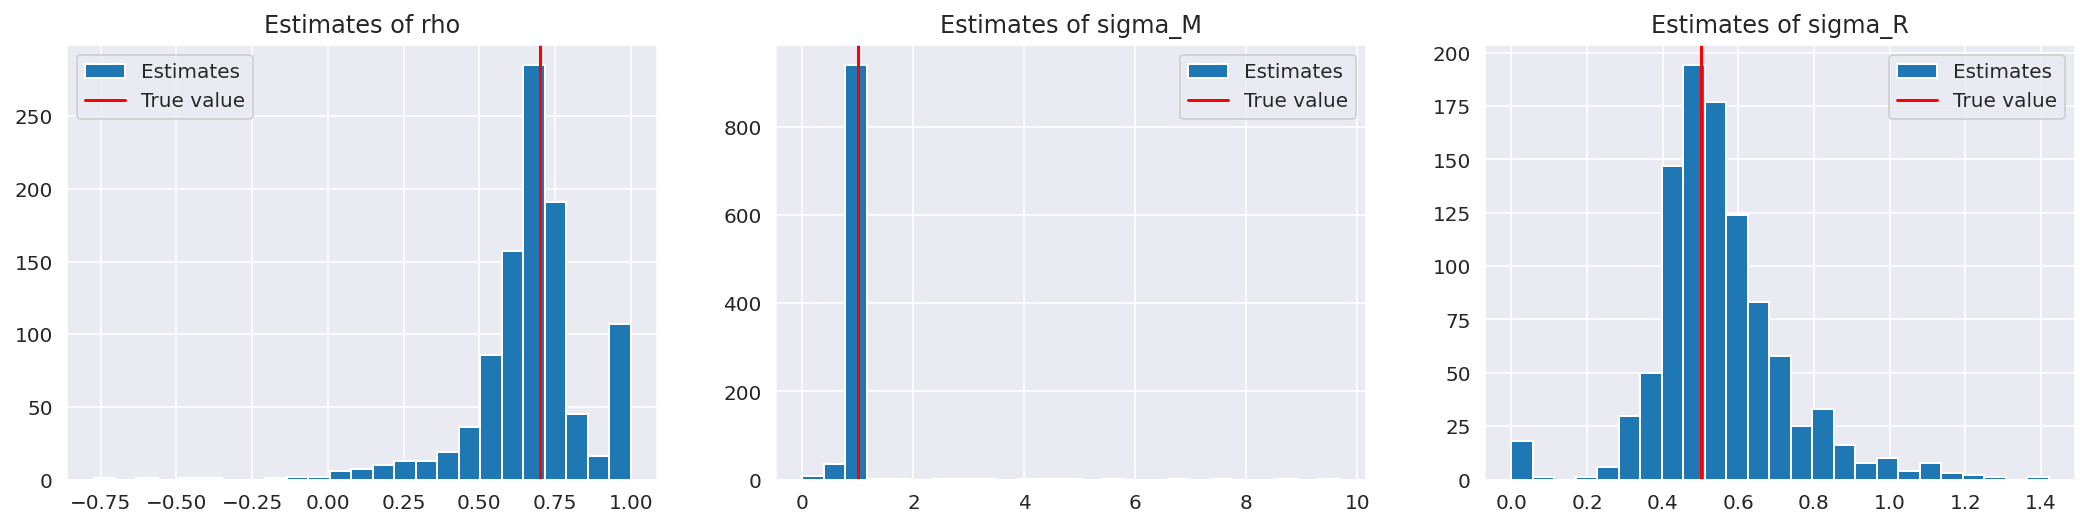

In [107]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(18,4))
ax1.hist(rhos, bins=25, label='Estimates')
ax1.set_title('Estimates of rho')
ax1.axvline(x=rho, label='True value', c='r')
ax1.legend()
ax2.hist(sigmaMs, bins=25, label='Estimates')
ax2.set_title('Estimates of sigma_M')
ax2.axvline(x=sigma_M, label='True value', c='r')
ax2.legend()
ax3.hist(sigmaRs, bins=25, label='Estimates')
ax3.set_title('Estimates of sigma_R')
ax3.axvline(x=sigma_R, label='True value', c='r')
ax3.legend()

## PAR mode + AR sample

In [110]:
sigma_M = 1
sigma_R = 0
rho = 0.7

In [111]:
rhos = []
sigmaMs = []
sigmaRs = []
N_sim = 1000
N = 500

for i in range(N_sim):
    np.random.seed(i)
    sample = generate_par(N, rho, sigma_M, sigma_R)
    params = mle_fit(sample, mode='PAR')
    rhos.append(params[0])
    sigmaMs.append(params[1])
    sigmaRs.append(params[2])

/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: divide by zero encountered in log
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: invalid value encountered in double_scalars
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)


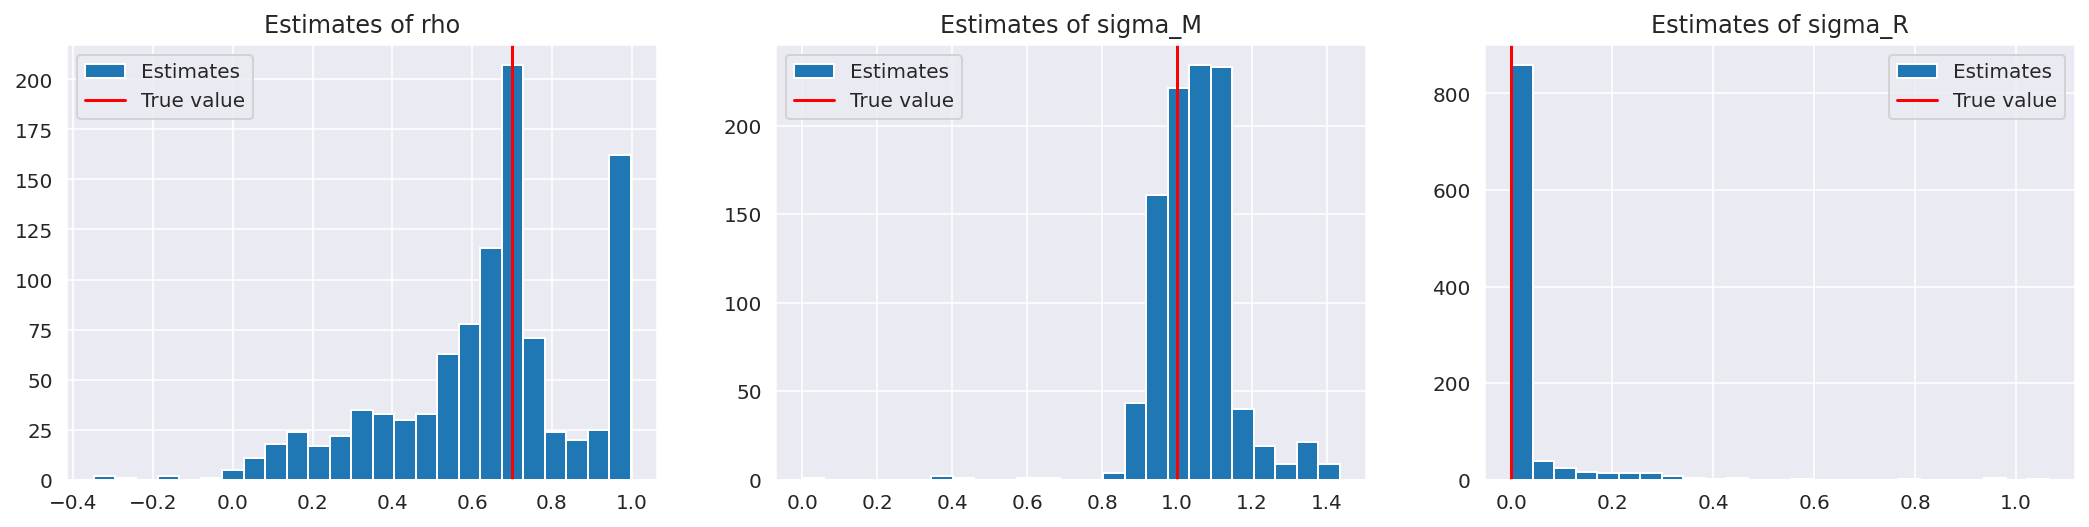

In [112]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(18,4))
ax1.hist(rhos, bins=25, label='Estimates')
ax1.set_title('Estimates of rho')
ax1.axvline(x=rho, label='True value', c='r')
ax1.legend()
ax2.hist(sigmaMs, bins=25, label='Estimates')
ax2.set_title('Estimates of sigma_M')
ax2.axvline(x=sigma_M, label='True value', c='r')
ax2.legend()
ax3.hist(sigmaRs, bins=25, label='Estimates')
ax3.set_title('Estimates of sigma_R')
ax3.axvline(x=sigma_R, label='True value', c='r')
ax3.legend()

## AR mode + AR sample

In [115]:
sigma_M = 1
sigma_R = 0
rho = 0.7

In [116]:
rhos = []
sigmaMs = []
N_sim = 1000
N = 500

for i in range(N_sim):
    np.random.seed(i)
    sample = generate_par(N, rho, sigma_M, sigma_R)
    params = mle_fit(sample, mode='AR')
    rhos.append(params[0])
    sigmaMs.append(params[1])

/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: divide by zero encountered in log
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: invalid value encountered in double_scalars
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)


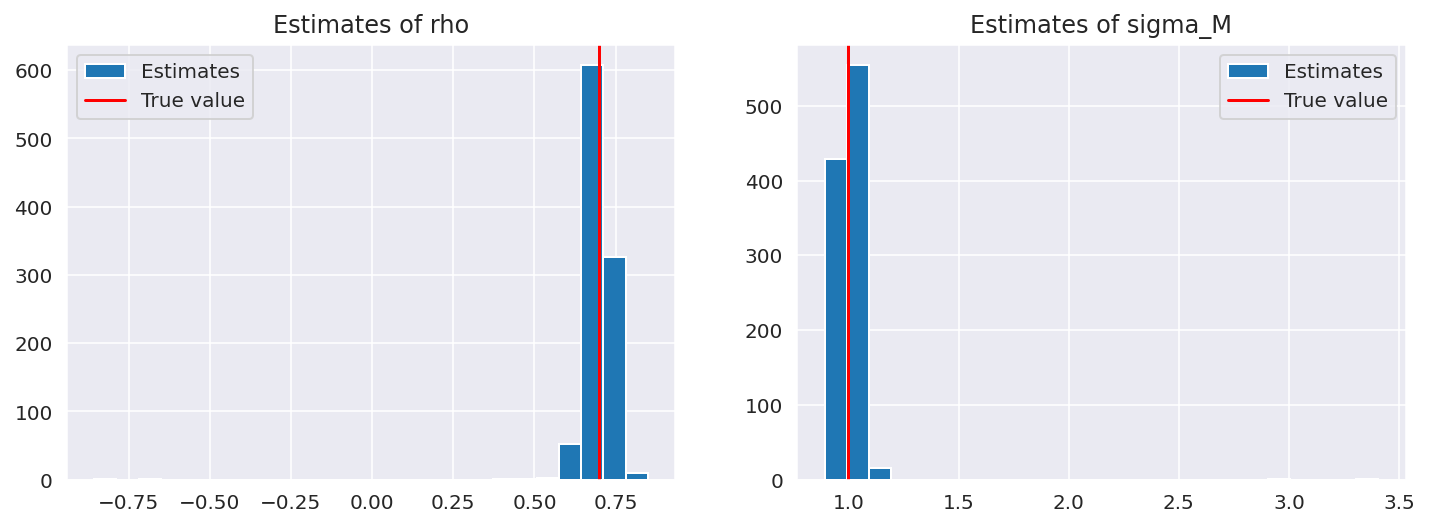

In [117]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.hist(rhos, bins=25, label='Estimates')
ax1.set_title('Estimates of rho')
ax1.axvline(x=rho, label='True value', c='r')
ax1.legend()
ax2.hist(sigmaMs, bins=25, label='Estimates')
ax2.set_title('Estimates of sigma_M')
ax2.axvline(x=sigma_M, label='True value', c='r')
ax2.legend()

## RW mode + RW sample

In [118]:
sigma_M = 0
sigma_R = 1
rho = 0

In [119]:
sigmaRs = []
N_sim = 1000
N = 500

for i in range(N_sim):
    np.random.seed(i)
    sample = generate_par(N, rho, sigma_M, sigma_R)
    params = mle_fit(sample, mode='RW')
    sigmaRs.append(params[0])

/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: divide by zero encountered in log
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: divide by zero encountered in true_divide
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: invalid value encountered in subtract
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)


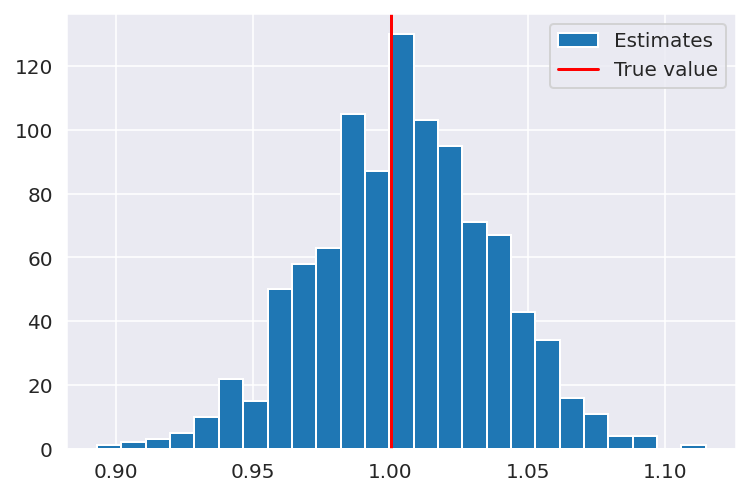

In [120]:
plt.hist(sigmaRs, bins=25, label='Estimates')
plt.axvline(x=sigma_R, label='True value', c='r')
plt.legend()

# Likelihood ratio test

## RW samples + RW null

In [121]:
rho = 0
sigma_M = 0
sigma_R = 1

n_sim = 1000
n_samples = 2500

lambdas = []

    
while len(lambdas)<n_sim:
    sample = generate_par(n_samples, rho, sigma_M, sigma_R)

    # log likelihood of RW
    sigmaR_rw = mle_fit(sample, mode='RW')
    ll_rw = log_like(sample, 0, 0, sigmaR_rw)

    # log likelihood of PAR
    rho_par, sigmaM_par, sigmaR_par = mle_fit(sample, mode='PAR')
    ll_par = log_like(sample, rho_par, sigmaM_par, sigmaR_par)

    lambdas.append(ll_rw - ll_par)

/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: divide by zero encountered in log
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: divide by zero encountered in true_divide
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: invalid value encountered in subtract
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: invalid value encountered in double_scalars
  ll = -(N-1)/2 * np.log(2*np.pi * (si

In [122]:
lambdas = np.array(lambdas)

In [123]:
np.quantile(lambdas, [0.01, 0.05, 0.1])

array([-2.11422562, -0.56744635, -0.16575175])

(array([737., 225.,  37.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.]),
 array([-4.96123383e+00,  5.32410994e+03,  1.06531811e+04,  1.59822523e+04,
         2.13113235e+04,  2.66403946e+04,  3.19694658e+04,  3.72985370e+04,
         4.26276082e+04,  4.79566793e+04,  5.32857505e+04,  5.86148217e+04,
         6.39438929e+04,  6.92729641e+04,  7.46020352e+04,  7.99311064e+04,
         8.52601776e+04,  9.05892488e+04,  9.59183199e+04,  1.01247391e+05,
         1.06576462e+05,  1.11905533e+05,  1.17234605e+05,  1.22563676e+05,
         1.27892747e+05,  1.33221818e+05]),
 <BarContainer object of 25 artists>)

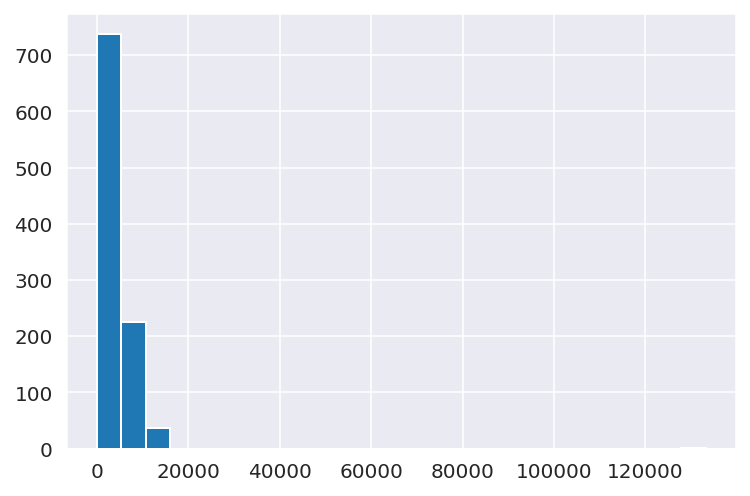

In [124]:
plt.hist(lambdas, bins=25)

In [125]:
np.quantile(lambdas[lambdas<0], [0.01, 0.05, 0.1])

array([-4.56084777, -2.09348944, -1.29538882])

# PAR with real data

In [183]:
data = pd.read_csv('vbr0214.csv', index_col=0)
data

,IEX,NUAN,MOH,NVAX,SBNY,...,PKI,ALGT,SAGE,OII,DRQ
2002-01-02,11.232835,3.852814,NaN,272.4,NaN,...,28.196012,NaN,NaN,4.741946,11.250
2002-01-03,11.397299,4.017316,NaN,266.0,NaN,...,28.872910,NaN,NaN,4.810350,11.220
2002-01-04,11.420323,4.329004,NaN,263.0,NaN,...,29.187184,NaN,NaN,4.843449,11.095
2002-01-07,11.364406,4.458874,NaN,263.0,NaN,...,28.244362,NaN,NaN,4.836829,11.600
2002-01-08,11.486109,4.701299,NaN,264.8,NaN,...,28.204070,NaN,NaN,4.841242,11.550
...,...,...,...,...,...,...,...,...,...,...,...
2013-12-24,65.672753,13.281385,33.51,101.6,101.676034,...,39.724403,95.280130,NaN,71.823160,110.660
2013-12-26,66.103865,13.090909,33.12,102.6,101.638345,...,39.685760,96.335122,NaN,71.695100,110.910
2013-12-27,66.032013,12.926407,33.21,102.6,101.421632,...,39.782366,93.179086,NaN,71.768277,111.110
2013-12-30,65.933217,12.995671,33.98,103.2,100.884561,...,39.946597,94.108909,NaN,71.685953,109.420


## Prices

In [129]:
start_years = [2002, 2004, 2006, 2008, 2010, 2012]
columns = ['AIC_AR', 'AIC_RW', 'AIC_PAR', 'rho', 'sigma_M', 'sigma_R', '$R^2_{MR}$']
results = {}

for sy in start_years:
    data_tmp = data.loc[f'{sy}-01-01':f'{sy+2}-01-01']
    data_tmp = data_tmp.dropna(axis=1)
    results_df = pd.DataFrame(columns=columns, index=data_tmp.columns)
    
    for s in data_tmp.columns:
        X = data_tmp[s].values

        # fit PAR
        rho_par, sigmaM_par, sigmaR_par = mle_fit(X, mode='PAR')
        ll_par = log_like(X, rho_par, sigmaM_par, sigmaR_par)
        aic_par = 2*3 - 2*ll_par

        # fit AR
        rho_ar, sigmaM_ar = mle_fit(X, mode='AR')
        ll_ar = log_like(X, rho_ar, sigmaM_ar, 0)
        aic_ar = 2*2 - 2*ll_ar

        # fit RW
        sigmaR_rw = mle_fit(X, mode='RW')
        ll_rw = log_like(X, 0, 0, sigmaR_rw)
        aic_rw = 2*1 - 2*ll_rw

        # calculate R^2
        r_sq = calculate_Rsq(rho_par, sigmaM_par, sigmaR_par)

        results_df.loc[s] = [aic_ar, aic_rw, aic_par, rho_par, sigmaM_par, sigmaR_par, r_sq]
        
    results[sy] = results_df

/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: divide by zero encountered in log
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: invalid value encountered in double_scalars
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarra

In [130]:
results[2002]

,AIC_AR,AIC_RW,AIC_PAR,rho,sigma_M,sigma_R,$R^2_{MR}$
IEX,-149.771318,[-151.77471622497103],2317.723444,-0.268035,1.029679,0.000102,1.0
NUAN,-2.381531,[-4.1794623638807025],-1.460939,0.67236,0.102024,0.21734,0.208565
NVAX,3264.365386,[3267.603860439341],3272.213,0.317392,0.493449,6.205497,0.009508
PWR,627.822877,[628.7462327731057],3236.698613,0.31107,5.998518,0.0,1.0
WSM,785.74759,[783.7475899593974],786.374403,0.972498,0.405678,0.336543,0.595684
...,...,...,...,...,...,...,...
HLX,135.293584,[132.7037763780508],240.044724,-0.698498,0.078861,0.232864,0.432073
RES,-1872.76093,[-1873.345457867264],-1869.345358,-0.331058,0.0,0.037525,0.0
PKI,595.554257,[602.053478083065],2750.971383,0.688391,4.02476,0.0,1.0
OII,-593.422499,[-595.5171691997487],-591.515974,-0.964314,0.0,0.133449,0.0


In [131]:
tmp = results[2002]
cond = (tmp['AIC_PAR'] == tmp[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
tmp[cond]

,AIC_AR,AIC_RW,AIC_PAR,rho,sigma_M,sigma_R,$R^2_{MR}$
CSL,354.678959,[352.67947064199086],352.031099,0.402764,0.137363,0.308634,0.220225
OSK,231.302665,[229.28530563834056],227.660979,-0.191959,0.08512,0.289763,0.175995
PVH,264.887757,[262.89037084792506],257.250799,0.703329,0.227289,0.210139,0.578707
MAT,-49.152215,[-51.152207625327264],-58.835636,0.626891,0.158116,0.161613,0.540592
NYT,889.808898,[887.6877802367438],880.966384,0.909251,0.533124,0.221611,0.858405
...,...,...,...,...,...,...,...
KELYA,1600.971578,[642.1971567731232],634.582989,-0.288211,0.138118,0.430338,0.22447
UFCS,-180.906978,[-182.90911975498017],-189.496651,0.552423,0.123601,0.156369,0.445963
BFS,-479.100359,[-481.32718045096567],-484.292641,-0.408266,0.031333,0.145261,0.135886
DBD,719.123191,[717.122673600367],714.408072,-0.14689,0.148518,0.468011,0.190995


In [132]:
sum_ind = ['2002-2003', '2004-2005', '2006-2007', '2008-2009', '2010-2011', '2012-2013']
sum_col = ['N', 'P_ar', 'P_rw', 'P_par', '$\overline{\rho}$', '$\overline{R}^2_{MR}$']
sum_df = pd.DataFrame(index=sum_ind, columns=sum_col)
sum_df

,N,P_ar,P_rw,P_par,$\overline{\rho}$,$\overline{R}^2_{MR}$
2002-2003,NaN,NaN,NaN,NaN,NaN,NaN
2004-2005,NaN,NaN,NaN,NaN,NaN,NaN
2006-2007,NaN,NaN,NaN,NaN,NaN,NaN
2008-2009,NaN,NaN,NaN,NaN,NaN,NaN
2010-2011,NaN,NaN,NaN,NaN,NaN,NaN
2012-2013,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
for sy in start_years:
    res = results[sy]
    N = len(res)
    cond_ar = (res['AIC_AR'] == res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    cond_rw = (res['AIC_RW'] == res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    cond_par = (res['AIC_PAR'] == res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    P_ar = len(res[cond_ar]) / N
    P_rw = len(res[cond_rw]) / N
    P_par = len(res[cond_par]) / N
    rho_bar = res[cond_par]['rho'].mean()
    rsq_bar = res[cond_par]['$R^2_{MR}$'].mean()
    sum_df.loc[f'{sy}-{sy+1}'] = [N, P_ar, P_rw, P_par, rho_bar, rsq_bar]

In [134]:
sum_df

,N,P_ar,P_rw,P_par,$\overline{\rho}$,$\overline{R}^2_{MR}$
2002-2003,465,0.019355,0.810753,0.169892,0.056728,0.369408
2004-2005,495,0.022222,0.834343,0.143434,0.296312,0.462505
2006-2007,525,0.017143,0.855238,0.127619,0.439629,0.494653
2008-2009,575,0.081739,0.669565,0.248696,0.316662,0.470534
2010-2011,596,0.005034,0.760067,0.234899,0.038972,0.312495
2012-2013,628,0.001592,0.934713,0.063694,0.081228,0.333117


In [144]:
sum_df.mean()

N                        547.333333
P_ar                       0.024514
P_rw                       0.810780
P_par                      0.164706
$\overline{\rho}$          0.204922
$\overline{R}^2_{MR}$      0.407119
dtype: float64

In [176]:
per_col = ['$N$', '$A_{t}$', '$A_{t-1}$', '$A_{t}|A_{t-1}$', '$p_t$', '$p_{t|t-1}$']
per_ind = sum_ind[1:]

per_df = pd.DataFrame(index=per_ind, columns=per_col)

for i in range(1,len(start_years)):
    cur_res = results[start_years[i]]
    prev_res = results[start_years[i-1]]
    N = len(cur_res)
    
    # calculate A_t
    cond = (cur_res['AIC_PAR'] == cur_res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    cur_symbols = cur_res[cond].index # stocks that are PAR in current period
    at0 = len(cur_symbols)
    
    # calculaye A_{t-1}
    cond = (prev_res['AIC_PAR'] == prev_res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    prev_symbols = prev_res[cond].index # stocks that are PAR in previous period
    at1 = len(prev_symbols)
    
    # calculate A_{t}|A_{t-1}
    symbols_is = set(cur_symbols).intersection(set(prev_symbols))
    at_is = len(symbols_is)
    
    p0 = at0 / N
    p1 = at_is / at1
    
    sy = start_years[i]
    per_df.loc[f'{sy}-{sy+1}'] = [N, at0, at1, at_is, p0, p1]

In [177]:
print(per_df)

           $N$ $A_{t}$ $A_{t-1}$ $A_{t}|A_{t-1}$     $p_t$ $p_{t|t-1}$
2004-2005  495      71        79              20  0.143434    0.253165
2006-2007  525      67        71              19  0.127619    0.267606
2008-2009  575     143        67              26  0.248696     0.38806
2010-2011  596     140       143              50  0.234899     0.34965
2012-2013  628      40       140              19  0.063694    0.135714


## Log prices

In [135]:
results_log = {}

for sy in start_years:
    data_tmp = data.loc[f'{sy}-01-01':f'{sy+2}-01-01']
    data_tmp = data_tmp.dropna(axis=1)
    results_df = pd.DataFrame(columns=columns, index=data_tmp.columns)
    
    for s in data_tmp.columns:
        X = np.log(data_tmp[s].values)

        # fit PAR
        rho_par, sigmaM_par, sigmaR_par = mle_fit(X, mode='PAR')
        ll_par = log_like(X, rho_par, sigmaM_par, sigmaR_par)
        aic_par = 2*3 - 2*ll_par

        # fit AR
        rho_ar, sigmaM_ar = mle_fit(X, mode='AR')
        ll_ar = log_like(X, rho_ar, sigmaM_ar, 0)
        aic_ar = 2*2 - 2*ll_ar

        # fit RW
        sigmaR_rw = mle_fit(X, mode='RW')
        ll_rw = log_like(X, 0, 0, sigmaR_rw)
        aic_rw = 2*1 - 2*ll_rw

        # calculate R^2
        r_sq = calculate_Rsq(rho_par, sigmaM_par, sigmaR_par)

        results_df.loc[s] = [aic_ar, aic_rw, aic_par, rho_par, sigmaM_par, sigmaR_par, r_sq]
        
    results_log[sy] = results_df

/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: divide by zero encountered in log
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/tmp/ipykernel_381314/3652796700.py:8: RuntimeWarning: invalid value encountered in double_scalars
  ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
/home/alex/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarra

In [136]:
tmp = results_log[2002]
cond = (tmp['AIC_PAR'] == tmp[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
tmp[cond]

,AIC_AR,AIC_RW,AIC_PAR,rho,sigma_M,sigma_R,$R^2_{MR}$
NUAN,-1532.298742,[-1561.5102110844193],-1562.777585,-0.981941,0.001354,0.050976,0.072493
PVH,-2270.528959,[-2272.5248504833726],-2279.03231,-0.500357,0.006003,0.024193,0.197706
OLN,-2356.263538,[-2358.3069084458657],-2360.870135,0.372244,0.011366,0.01999,0.320264
PBCT,1166.272941,[-2857.6520069955536],-2861.604636,-0.635529,0.002006,0.014746,0.092175
DECK,-1807.688883,[-1809.68900489215],-1819.106379,-0.647267,0.006845,0.038887,0.149436
UMPQ,-2487.092933,[-2480.507823037904],-2499.424932,0.131254,0.010369,0.016993,0.396947
WTFC,-2491.11845,[-2493.1180798853175],-2498.555072,-0.663364,0.003018,0.019072,0.129482
WEN,-2777.777587,[-2775.5067997157366],-2782.63526,0.276808,0.007984,0.013046,0.369771
HWC,-2678.782502,[-2680.8805980737566],-2692.946359,-0.651189,0.003381,0.015935,0.205195
KFY,-1802.858703,[-1804.735124643824],-1824.401464,-0.352774,0.014707,0.038664,0.308979


In [137]:
logsum_df = pd.DataFrame(index=sum_ind, columns=sum_col)
logsum_df

,N,P_ar,P_rw,P_par,$\overline{\rho}$,$\overline{R}^2_{MR}$
2002-2003,NaN,NaN,NaN,NaN,NaN,NaN
2004-2005,NaN,NaN,NaN,NaN,NaN,NaN
2006-2007,NaN,NaN,NaN,NaN,NaN,NaN
2008-2009,NaN,NaN,NaN,NaN,NaN,NaN
2010-2011,NaN,NaN,NaN,NaN,NaN,NaN
2012-2013,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
for sy in start_years:
    res = results_log[sy]
    N = len(res)
    cond_ar = (res['AIC_AR'] == res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    cond_rw = (res['AIC_RW'] == res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    cond_par = (res['AIC_PAR'] == res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    P_ar = len(res[cond_ar]) / N
    P_rw = len(res[cond_rw]) / N
    P_par = len(res[cond_par]) / N
    rho_bar = res[cond_par]['rho'].mean()
    rsq_bar = res[cond_par]['$R^2_{MR}$'].mean()
    logsum_df.loc[f'{sy}-{sy+1}'] = [N, P_ar, P_rw, P_par, rho_bar, rsq_bar]

In [141]:
logsum_df

,N,P_ar,P_rw,P_par,$\overline{\rho}$,$\overline{R}^2_{MR}$
2002-2003,465,0.012903,0.911828,0.075269,-0.069599,0.351078
2004-2005,495,0.016162,0.939394,0.044444,0.082782,0.34994
2006-2007,525,0.015238,0.929524,0.055238,0.415138,0.514604
2008-2009,575,0.02087,0.885217,0.093913,0.234281,0.428911
2010-2011,596,0.018456,0.887584,0.09396,-0.210105,0.273762
2012-2013,628,0.009554,0.976115,0.014331,-0.376205,0.217011
